In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys, os
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [3]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")

In [ ]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

In [6]:
num_qubits = backend.configuration().n_qubits
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
dt = backend.configuration().dt
basis_gates = backend.configuration().basis_gates
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

# Helper Fcuntions

In [8]:
def gen_circ(state, basis_gate, sched, cx_pairs = None):
    num_qubits = sched.backend.configuration().num_qubits

    qubit_list = list(range(num_qubits))
    
    circ = QuantumCircuit(num_qubits)
    if basis_gate != 'cx':
        if state == -1:
            pass
        elif state == 0:
            pass
            # if add_delay:
            #     circ.delay(x_duration + x12_duration + x23_duration, qubit_list)
        elif state == 1:
            # if add_delay:
            #     circ.delay(x12_duration + x23_duration, qubit_list)
            circ.x(qubit_list)
        elif state == 2:
            # if add_delay:
            #     circ.delay(x23_duration, qubit_list)

            circ.x(qubit_list)

            if not sched:
                raise("Please specify Sched class!")
            x12_gate = Gate("x12_gate", 1, [])
            for i, qubit in enumerate(qubit_list):
                circ.append(x12_gate, [qubit])
                circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
        elif state == 3:
            circ.x(qubit_list)

            if not sched:
                raise("Please specify Sched class!")

            x12_gate = Gate("x12_gate", 1, [])
            x23_gate = Gate("x23_gate", 1, [])
            for i, qubit in enumerate(qubit_list):
                circ.append(x12_gate, [qubit])
                circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                circ.append(x23_gate, [qubit])
                circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
    
        circ.barrier()
        if basis_gate == None:
            pass
        elif basis_gate == 'rz':
            circ.rz(np.pi, qubit_list)
        elif basis_gate == 'sx':
            circ.sx(qubit_list)
        elif basis_gate == 'x':
            circ.x(qubit_list)
        elif basis_gate == 'reset':
            circ.reset(qubit_list)
            
            
    elif basis_gate == 'cx':
        for cx_pair in cx_pairs:
            circ.x(cx_pair[0])
            if state == 0:
                pass
            elif state == 1:
                circ.x(cx_pair[1])
            elif state == 2:
                circ.x(cx_pair[1])
                x12_gate = Gate("x12_gate", 1, [])
                circ.append(x12_gate, [cx_pair[1]])
                circ.add_calibration(x12_gate, (cx_pair[1], ), sched.get_sched(label = 'X12', qubit = cx_pair[1]))
            elif state == 3:
                circ.x(cx_pair[1])
                x12_gate = Gate("x12_gate", 1, [])
                x23_gate = Gate("x23_gate", 1, [])
                circ.append(x12_gate, [cx_pair[1]])
                circ.add_calibration(x12_gate, (cx_pair[1], ), sched.get_sched(label = 'X12', qubit = cx_pair[1]))
                circ.append(x23_gate, [cx_pair[1]])
                circ.add_calibration(x23_gate, (cx_pair[1], ), sched.get_sched(label = 'X23', qubit = cx_pair[1]))
        circ.barrier()
        for cx_pair in cx_pairs:
            circ.cx(cx_pair[0], cx_pair[1])
            
    circ.measure_all()
    
    return circ

# Experiment for Different Basis Gates

``exp_circs`` containing different states before the reset gate, different numbers of reset gates, 

## Experiment

### $P(|1\rangle)$

In [9]:
shots = 10000

In [10]:
cx_pairs = [[1, 0],
            [0, 1],
            [1, 2],
            [1, 3],
            [5, 4],
            [4, 5],
            [5, 6]]

exp_circs = []

for state in [1, 2, 3]:
    exp_circs_state = []
    for basis_gate in [None, 'rz', 'sx', 'x', 'reset', 'cx']:
        if basis_gate != 'cx':
            exp_circs_state.append(gen_circ(state, basis_gate, sched))
        else:
            for cx_pair in cx_pairs:
                exp_circs_state.append(gen_circ(state, basis_gate, sched, [cx_pair]))
    exp_circs.append(exp_circs_state)

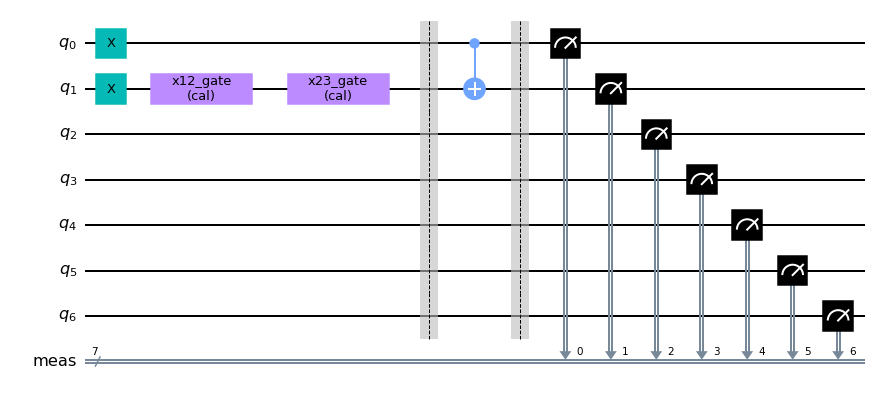

In [11]:
exp_circs[2][6].draw()

In [12]:
# job_list = []
# job_id_list = []
# for exp_circ in exp_circs:
#     job = backend.run(exp_circ, shots=shots, rep_delay=500e-6)
#     job_list.append(job)
#     job_id_list.append(job.job_id())
# job_id_list

['63384ed683172d7c5bd180a9',
 '63384ed85706bc8fb3465993',
 '63384edadee3d612d4b9122e']

In [11]:
# job_id_list = ['63384ed683172d7c5bd180a9',
#  '63384ed85706bc8fb3465993',
#  '63384edadee3d612d4b9122e']
# job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
# save_job(job_list, "data/basis_gate_tomography.pickle")

In [ ]:
# job_list = load_job("data/basis_gate_tomography.pickle")

In [12]:
# data = np.array([[single_qubit_count(job.result().get_counts(), qubit) for qubit in range(num_qubits)] for job in job_list])/shots
# save_job(data, "data/basis_gate_tomography_data.pickle")

In [ ]:
data = load_job("data/basis_gate_tomography_data.pickle")

In [13]:
data.shape

(3, 7, 12, 2)

In [17]:
for state in range(3):
    print(f"|{state+1}>")
    print("Qubit\t\t\t" + "\t\t\t".join([str(i) for i in range(num_qubits)]) + "\t\t\tAverage")
    # for qubit in range(num_qubit):
    print("No gate\t\t" + "\t\t".join([str(i) for i in np.append(data[state, :, 0, 1], [np.mean(data[state, :, 0, 1])])]))
    print("RZ\t\t\t" + "\t\t".join([str(round(i, 4)) for i in np.append(data[state, :, 1, 1] - data[state, :, 0, 1], np.mean(data[state, :, 1, 1] - data[state, :, 0, 1]))]))
    print("SX\t\t\t" + "\t\t".join([str(round(i, 4)) for i in np.append(data[state, :, 2, 1] - data[state, :, 0, 1], np.mean(data[state, :, 2, 1] - data[state, :, 0, 1]))]))
    print("X\t\t\t" + "\t\t".join([str(round(i, 4)) for i in np.append(data[state, :, 3, 1] - data[state, :, 0, 1], np.mean(data[state, :, 3, 1] - data[state, :, 0, 1]))]))
    print("Reset\t\t\t" + "\t\t".join([str(round(i, 4)) for i in np.append(data[state, :, 4, 1] - data[state, :, 0, 1], np.mean(data[state, :, 4, 1] - data[state, :, 0, 1]))]))
    print("CNOT\t\t" + "\t\t".join([str(round(i, 4)) for i in np.append([data[state, qubit, 5+qubit, 1] - data[state, qubit, 0, 1] for qubit in range(num_qubits)], np.mean([data[state, qubit, 5+qubit, 1] - data[state, qubit, 0, 1] for qubit in range(num_qubits)]))]))
    print()
    print()

|1>
Qubit			0			1			2			3			4			5			6			Average
No gate		0.9924		0.9903		0.9932		0.9899		0.9874		0.986		0.9899		0.9898714285714286
RZ			0.0012		-0.0018		-0.0028		-0.0012		-0.0008		0.0005		-0.0007		-0.0008
SX			-0.4907		-0.4839		-0.497		-0.4706		-0.4777		-0.4743		-0.5025		-0.4852
X			-0.9798		-0.9791		-0.9884		-0.9503		-0.9738		-0.9678		-0.9824		-0.9745
Reset			-0.9717		-0.9686		-0.9712		-0.9309		-0.9404		-0.9633		-0.9772		-0.9605
CNOT		-0.9678		-0.9671		-0.9761		-0.9434		-0.9522		-0.9516		-0.9703		-0.9612


|2>
Qubit			0			1			2			3			4			5			6			Average
No gate		0.9617		0.99		0.9821		0.9311		0.9758		0.9663		0.9816		0.9698000000000001
RZ			0.0003		0.0011		-0.001		0.0027		0.0036		-0.0049		0.0009		0.0004
SX			-0.0071		-0.0005		-0.0041		-0.0026		-0.0019		-0.0096		-0.0053		-0.0044
X			-0.0188		-0.0004		-0.0122		-0.0113		-0.0099		-0.0221		-0.0124		-0.0124
Reset			-0.0539		-0.0333		-0.1143		-0.0618		-0.0432		-0.1351		-0.0582		-0.0714
CNOT		-0.022		-0.0053		-0.0298		-0.02		-0.0022		-0.0604		-